2025-11-06 10:24:39,048 - INFO - Initializing Legal GAT Trainer on device: cpu
2025-11-06 10:24:39,049 - INFO - Loading graph data from KG pipeline...
2025-11-06 10:24:39,549 - INFO - Loaded graph with 154068 nodes and 725563 edges
2025-11-06 10:24:39,550 - INFO - 
Training GAT on Node Type Classification...
2025-11-06 10:24:39,551 - INFO - 

2025-11-06 10:24:39,551 - INFO - Training GAT Model:
2025-11-06 10:24:39,551 - INFO - Creating labels for task: node_type
2025-11-06 10:24:39,591 - INFO - Created 9 classes for 'node_type' task
2025-11-06 10:24:39,592 - INFO - Label distribution: {'act': 79548, 'case': 56025, 'concept': 16, 'doctrine': 15, 'high_court': 5, 'judge': 766, 'provision': 17691, 'supreme_court': 1, 'supreme_court_cases': 1}
2025-11-06 10:24:39,601 - INFO - Split - Train: 107847, Val: 23110, Test: 23111
2025-11-06 10:24:39,646 - INFO - Initialized homogeneous GAT model
2025-11-06 10:24:39,647 - INFO -   Hidden channels: 128
2025-11-06 10:24:39,647 - INFO -   Attention he

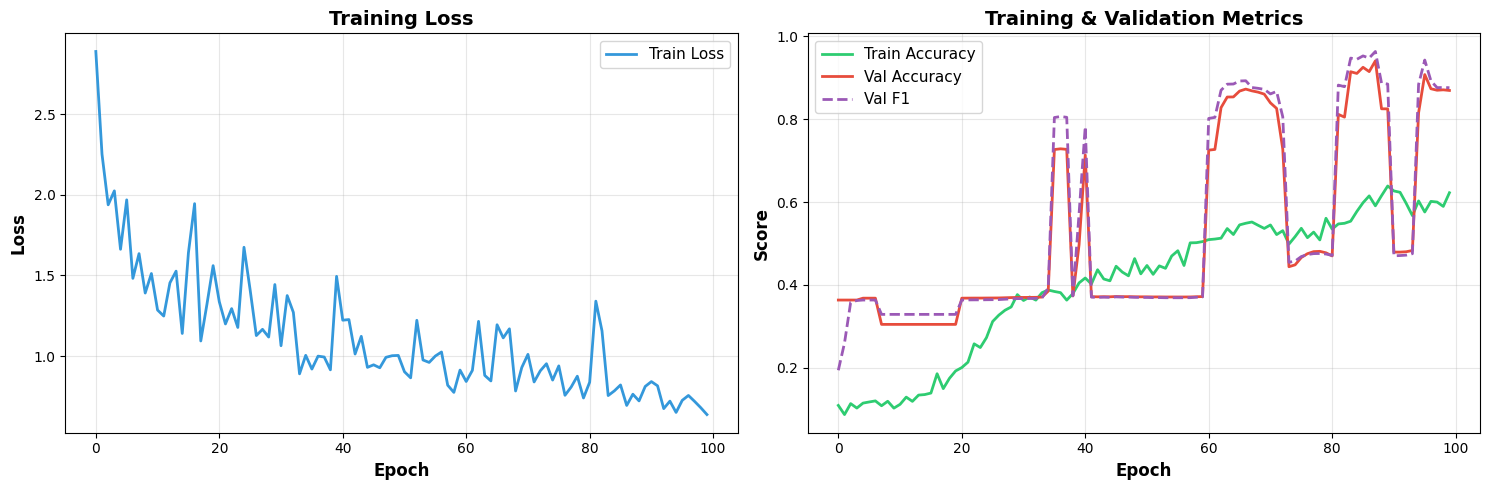

2025-11-06 11:00:00,347 - INFO - Training curves saved to gnn_data/training_curves.png
2025-11-06 11:00:00,352 - INFO - 
Generating t-SNE visualization...
2025-11-06 11:00:06,395 - INFO - Computing t-SNE projection...
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


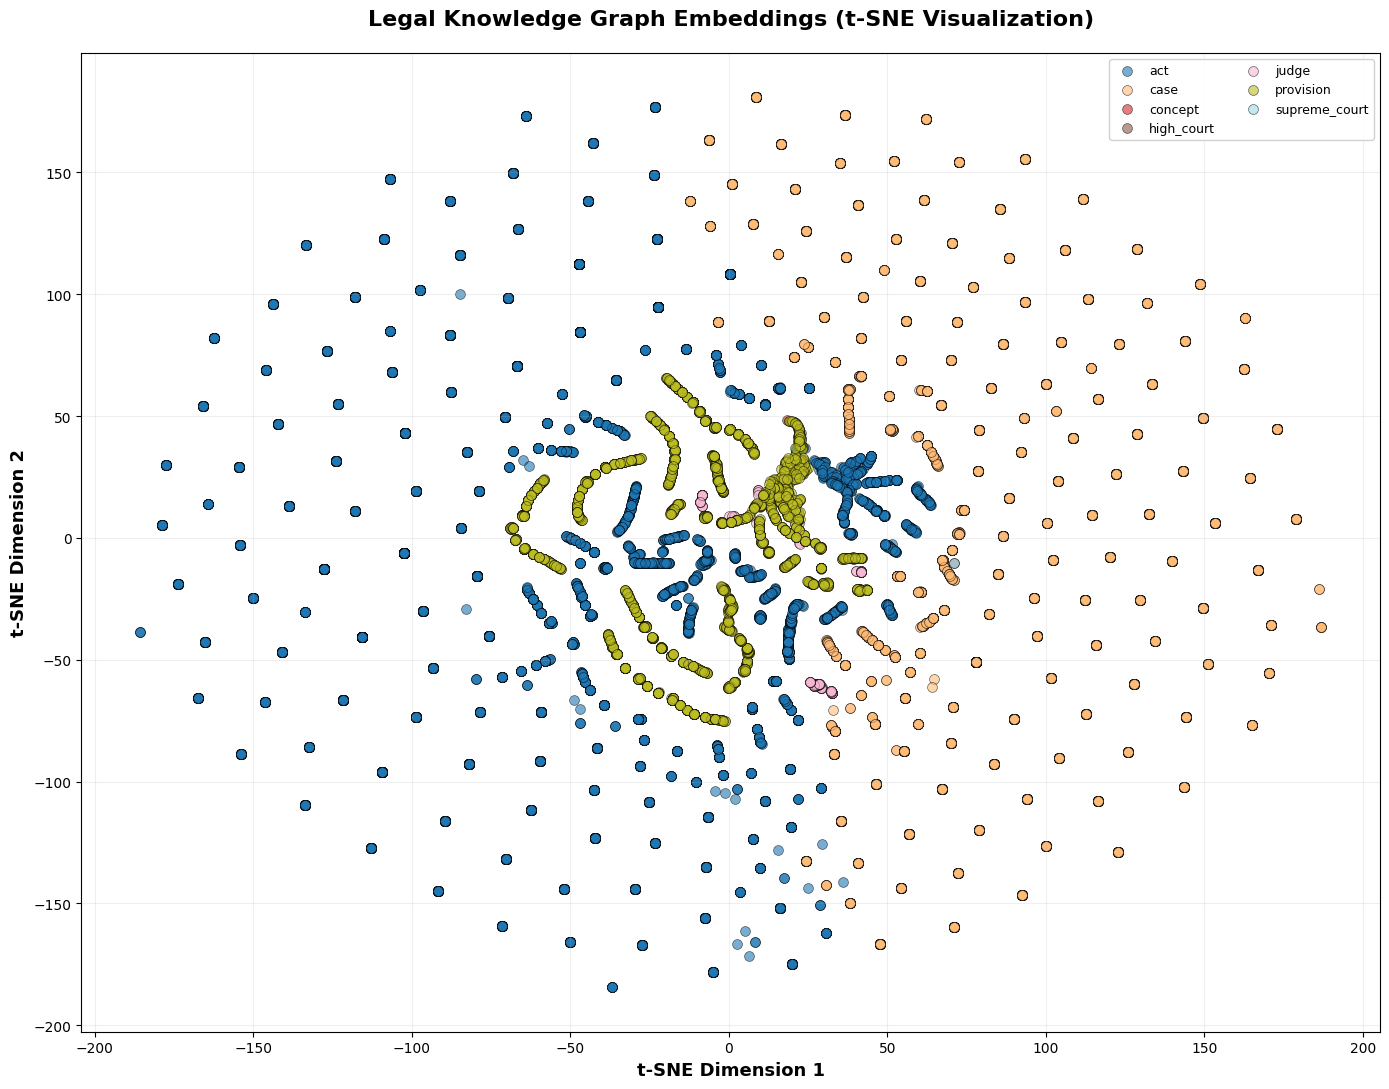

2025-11-06 11:00:33,344 - INFO - t-SNE visualization saved to gnn_data/embeddings_tsne.png
2025-11-06 11:00:33,345 - INFO - 
Analyzing attention weights...
2025-11-06 11:00:33,618 - INFO - Extracting attention weights for node 7...


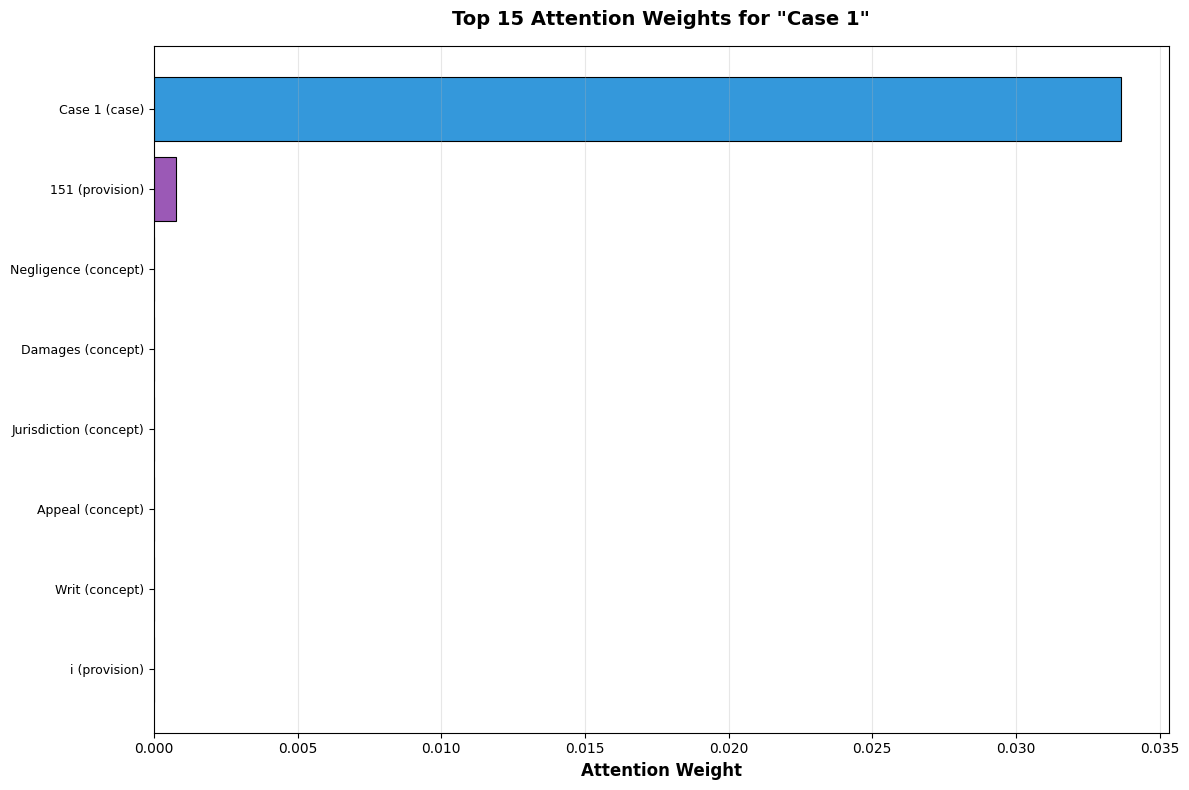

2025-11-06 11:00:41,326 - INFO - Attention visualization saved to gnn_data/attention_weights_node_7.png
2025-11-06 11:00:41,328 - INFO - 
Attention analysis for case node 7:
2025-11-06 11:00:41,328 - INFO - Top 5 attended neighbors:
2025-11-06 11:00:41,329 - INFO -   1. Case 1 (case) - Attention: 0.0336
2025-11-06 11:00:41,329 - INFO -   2. 151 (provision) - Attention: 0.0008
2025-11-06 11:00:41,329 - INFO -   3. Negligence (concept) - Attention: 0.0000
2025-11-06 11:00:41,330 - INFO -   4. Damages (concept) - Attention: 0.0000
2025-11-06 11:00:41,330 - INFO -   5. Jurisdiction (concept) - Attention: 0.0000
2025-11-06 11:00:41,331 - INFO - 
Exporting node embeddings...
2025-11-06 11:00:41,331 - INFO - Exporting embeddings for task: node_type...
2025-11-06 11:00:49,106 - INFO - Embeddings shape: (154068, 128)
2025-11-06 11:00:49,106 - INFO - Saved to: final_embeddings_node_type.npy
2025-11-06 11:00:49,107 - INFO - Metadata saved to: embedding_metadata_node_type.json
2025-11-06 11:00:49,

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, Linear, HeteroConv
from torch_geometric.data import Data, HeteroData
from torch_geometric.loader import NeighborLoader
import numpy as np
import json
import networkx as nx
from pathlib import Path
from typing import Dict, List, Tuple, Optional
import logging
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import pandas as pd
from torch.optim import AdamW
torch.manual_seed(42)
np.random.seed(42)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)
class LegalCaseGAT(nn.Module):
    def __init__(self, num_node_features: int, hidden_channels: int, 
                 num_classes: int, num_heads: int = 4, num_layers: int = 3,
                 dropout: float = 0.5, edge_dim: int = 4, drop_rate: float = 0.2):
        super(LegalCaseGAT, self).__init__()
        self.num_layers = num_layers
        self.dropout = dropout
        self.drop_rate = drop_rate        
        self.input_proj = Linear(num_node_features, hidden_channels)        
        self.convs = nn.ModuleList()
        self.batch_norms = nn.ModuleList()        
        self.convs.append(
            GATv2Conv(
                hidden_channels, hidden_channels,
                heads=num_heads, dropout=dropout,
                edge_dim=edge_dim, add_self_loops=True,
                concat=True))
        self.batch_norms.append(nn.BatchNorm1d(hidden_channels * num_heads))
        for _ in range(num_layers - 2):
            self.convs.append(
                GATv2Conv(
                    hidden_channels * num_heads,
                    hidden_channels, heads=num_heads,
                    dropout=dropout, edge_dim=edge_dim,
                    add_self_loops=True, concat=True))
            self.batch_norms.append(nn.BatchNorm1d(hidden_channels * num_heads))
        self.convs.append(
            GATv2Conv(
                hidden_channels * num_heads, hidden_channels,
                heads=1, dropout=dropout,
                edge_dim=edge_dim, add_self_loops=True,
                concat=False))
        self.batch_norms.append(nn.BatchNorm1d(hidden_channels))
        self.classifier = Linear(hidden_channels, num_classes)
        self.residual_projs = nn.ModuleList([
            Linear(hidden_channels if i == 0 else hidden_channels * num_heads, 
                   hidden_channels * num_heads if i < num_layers - 1 else hidden_channels)
            for i in range(num_layers)])
    def forward(self, x, edge_index, edge_attr=None, return_attention_weights=False):
        if self.training and self.drop_rate > 0:
            num_edges = edge_index.size(1)
            mask = torch.rand(num_edges, device=edge_index.device) > self.drop_rate
            edge_index = edge_index[:, mask]
            if edge_attr is not None:
                edge_attr = edge_attr[mask]        
        x = self.input_proj(x)
        x = F.elu(x)
        attention_weights_list = []
        for i, (conv, bn, res_proj) in enumerate(zip(self.convs, self.batch_norms, self.residual_projs)):
            x_residual = res_proj(x)
            if return_attention_weights and i == self.num_layers - 1:
                x_new, attention_weights = conv(x, edge_index, edge_attr, 
                                               return_attention_weights=True)
                attention_weights_list.append(attention_weights)
            else:
                x_new = conv(x, edge_index, edge_attr)
            x_new = bn(x_new)
            x_new = F.elu(x_new)            
            x = x_new + x_residual
            if i < self.num_layers - 1:
                x = F.dropout(x, p=self.dropout, training=self.training)        
        embeddings = x
        logits = self.classifier(embeddings)
        if return_attention_weights:
            return logits, embeddings, attention_weights_list
        return logits, embeddings
class HeteroLegalGAT(nn.Module):    
    def __init__(self, node_types: List[str], edge_types: List[Tuple[str, str, str]],
                 num_node_features: int, hidden_channels: int, num_classes: int,
                 num_heads: int = 4, num_layers: int = 3, dropout: float = 0.5):
        super(HeteroLegalGAT, self).__init__()        
        self.num_layers = num_layers
        self.dropout = dropout
        self.node_types = node_types
        self.input_projs = nn.ModuleDict({
            node_type: Linear(num_node_features, hidden_channels)
            for node_type in node_types})        
        self.convs = nn.ModuleList()
        for i in range(num_layers):
            in_channels = hidden_channels if i == 0 else hidden_channels * num_heads
            out_channels = hidden_channels
            heads = num_heads if i < num_layers - 1 else 1
            concat = i < num_layers - 1
            conv_dict = {}
            for edge_type in edge_types:
                conv_dict[edge_type] = GATv2Conv(
                    (-1, -1), out_channels, heads=heads,
                    dropout=dropout, add_self_loops=False, concat=concat)
            self.convs.append(HeteroConv(conv_dict, aggr='mean'))
        self.classifiers = nn.ModuleDict({
            node_type: Linear(hidden_channels, num_classes)
            for node_type in node_types})
    def forward(self, x_dict, edge_index_dict):
        x_dict = {
            node_type: F.elu(self.input_projs[node_type](x))
            for node_type, x in x_dict.items()}        
        for i, conv in enumerate(self.convs):
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: F.elu(x) for key, x in x_dict.items()}
            if i < self.num_layers - 1:
                x_dict = {key: F.dropout(x, p=self.dropout, training=self.training)
                         for key, x in x_dict.items()}        
        embeddings_dict = x_dict
        logits_dict = {
            node_type: self.classifiers[node_type](x)
            for node_type, x in x_dict.items()}
        return logits_dict, embeddings_dict
class LegalGATTrainer:    
    def __init__(self, gnn_data_dir: str = "gnn_data", device: str = None):
        self.gnn_data_dir = Path(gnn_data_dir)        
        if device is None:
            if torch.cuda.is_available():
                self.device = 'cuda'
            else:
                self.device = 'cpu'
        else:
            self.device = device
        logger.info(f"Initializing Legal GAT Trainer on device: {self.device}")
        self.data = None
        self.model = None
        self.optimizer = None
        self.train_history = defaultdict(list)
    def load_data(self) -> Data:
        logger.info("Loading graph data from KG pipeline...")
        node_features = np.load(self.gnn_data_dir / 'node_features.npy')
        node_features = torch.tensor(node_features, dtype=torch.float)        
        edge_list = np.load(self.gnn_data_dir / 'edge_list.npy')
        edge_index = torch.tensor(edge_list.T, dtype=torch.long)
        edge_features = np.load(self.gnn_data_dir / 'edge_features.npy')
        edge_attr = torch.tensor(edge_features, dtype=torch.float)        
        with open(self.gnn_data_dir / 'node_metadata.json', 'r') as f:
            node_metadata = json.load(f)
        with open(self.gnn_data_dir / 'graph_stats.json', 'r') as f:
            graph_stats = json.load(f)
        logger.info(f"Loaded graph with {node_features.shape[0]} nodes and {edge_index.shape[1]} edges")
        data = Data(
            x=node_features, edge_index=edge_index,
            edge_attr=edge_attr, num_nodes=node_features.shape[0])
        data.node_metadata = node_metadata
        data.graph_stats = graph_stats
        self.data = data
        self.node_metadata = node_metadata
        self.graph_stats = graph_stats
        return data
    def create_task_labels(self, task: str = 'node_type') -> Tuple[torch.Tensor, int, Dict]:
        logger.info(f"Creating labels for task: {task}")
        num_nodes = len(self.node_metadata)
        if task == 'node_type':
            unique_types = set()
            for node in self.node_metadata:
                node_type = node.get('type', 'case')
                unique_types.add(node_type)
            node_type_to_label = {t: idx for idx, t in enumerate(sorted(unique_types))}
            labels = [node_type_to_label[node.get('type', 'case')] for node in self.node_metadata]
            num_classes = len(node_type_to_label)
            label_info = {
                'mapping': node_type_to_label,
                'reverse_mapping': {v: k for k, v in node_type_to_label.items()}}
        elif task == 'importance':
            labels = []
            for node in self.node_metadata:
                attrs = node.get('attributes', {})
                citation_count = attrs.get('citation_count', 0)
                mention_count = attrs.get('mention_count', 0)
                importance = citation_count + mention_count
                if importance == 0:
                    labels.append(0)
                elif importance < 5:
                    labels.append(1)
                else:
                    labels.append(2) 
            num_classes = 3
            label_info = {
                'mapping': {'Low': 0, 'Medium': 1, 'High': 2},
                'reverse_mapping': {0: 'Low', 1: 'Medium', 2: 'High'}}
        elif task == 'validation':
            labels = []
            for node in self.node_metadata:
                attrs = node.get('attributes', {})
                validated = attrs.get('validated', False)
                labels.append(1 if validated else 0)
            num_classes = 2
            label_info = {
                'mapping': {'Not Validated': 0, 'Validated': 1},
                'reverse_mapping': {0: 'Not Validated', 1: 'Validated'}}
        elif task == 'provision_classification':
            parent_acts = set()
            for node in self.node_metadata:
                attrs = node.get('attributes', {})
                parent_act = attrs.get('parent_act', 'Unknown')
                if parent_act != 'Unknown':
                    parent_acts.add(parent_act)
            parent_act_to_label = {act: idx for idx, act in enumerate(sorted(parent_acts))}
            parent_act_to_label['Unknown'] = len(parent_act_to_label)
            labels = []
            for node in self.node_metadata:
                attrs = node.get('attributes', {})
                parent_act = attrs.get('parent_act', 'Unknown')
                labels.append(parent_act_to_label.get(parent_act, len(parent_act_to_label) - 1))
            num_classes = len(parent_act_to_label)
            label_info = {
                'mapping': parent_act_to_label,
                'reverse_mapping': {v: k for k, v in parent_act_to_label.items()}}
        else:
            raise ValueError(f"Unknown task: {task}")
        labels = torch.tensor(labels, dtype=torch.long)
        label_counts = torch.bincount(labels)
        label_info['distribution'] = {
            label_info['reverse_mapping'][i]: int(count) 
            for i, count in enumerate(label_counts)}
        class_weights = torch.ones(num_classes, dtype=torch.float)
        valid_counts = label_counts[label_counts > 0]
        if len(valid_counts) > 0:
            class_weights[label_counts > 0] = num_nodes / (len(valid_counts) * valid_counts.float())
        label_info['class_weights'] = class_weights
        logger.info(f"Created {num_classes} classes for '{task}' task")
        logger.info(f"Label distribution: {label_info['distribution']}")
        return labels, num_classes, label_info
    def create_train_val_test_split(self, labels: torch.Tensor, train_ratio: float = 0.7, val_ratio: float = 0.15,
                                    test_ratio: float = 0.15) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        num_nodes = len(labels)
        indices = torch.arange(num_nodes)
        labels_np = labels.numpy()
        indices_np = indices.numpy()
        class_counts = np.bincount(labels_np)
        present_class_counts = class_counts[class_counts > 0]
        min_count = np.min(present_class_counts) if len(present_class_counts) > 0 else 0
        if min_count < 2:
            stratify_first = None
        else:
            stratify_first = labels_np
        train_idx, temp_idx = train_test_split(
            indices_np, train_size=train_ratio,
            stratify=stratify_first, random_state=42)        
        temp_labels = labels_np[temp_idx]
        class_counts_temp = np.bincount(temp_labels)
        present_class_counts_temp = class_counts_temp[class_counts_temp > 0]
        min_count_temp = np.min(present_class_counts_temp) if len(present_class_counts_temp) > 0 else 0
        if min_count_temp < 2:
            stratify_second = None
        else:
            stratify_second = temp_labels
        val_size = val_ratio / (val_ratio + test_ratio)
        val_idx, test_idx = train_test_split(
            temp_idx, train_size=val_size,
            stratify=stratify_second, random_state=42)        
        train_mask = torch.zeros(num_nodes, dtype=torch.bool)
        val_mask = torch.zeros(num_nodes, dtype=torch.bool)
        test_mask = torch.zeros(num_nodes, dtype=torch.bool)
        train_mask[train_idx] = True
        val_mask[val_idx] = True
        test_mask[test_idx] = True
        logger.info(f"Split - Train: {train_mask.sum()}, Val: {val_mask.sum()}, Test: {test_mask.sum()}")
        return train_mask, val_mask, test_mask
    def initialize_model(self, num_classes: int, hidden_channels: int = 128,
                        num_heads: int = 4, num_layers: int = 3,
                        dropout: float = 0.5, model_type: str = 'homogeneous', drop_rate: float = 0.2):
        num_node_features = self.data.x.shape[1]
        edge_dim = self.data.edge_attr.shape[1]
        if model_type == 'homogeneous':
            self.model = LegalCaseGAT(
                num_node_features=num_node_features, hidden_channels=hidden_channels,
                num_classes=num_classes, num_heads=num_heads, num_layers=num_layers,
                dropout=dropout, edge_dim=edge_dim, drop_rate=drop_rate).to(self.device)
        else:
            raise NotImplementedError("Heterogeneous model not yet fully implemented")
        logger.info(f"Initialized {model_type} GAT model")
        logger.info(f"  Hidden channels: {hidden_channels}")
        logger.info(f"  Attention heads: {num_heads}")
        logger.info(f"  Number of layers: {num_layers}")
        logger.info(f"  Dropout: {dropout}")
        logger.info(f"  Drop rate: {drop_rate}")
        logger.info(f"  Total parameters: {sum(p.numel() for p in self.model.parameters()):,}")
        return self.model
    def train_epoch(self, optimizer, criterion, train_mask):
        self.model.train()        
        optimizer.zero_grad()    
        logits, embeddings = self.model(
            self.data.x.to(self.device), self.data.edge_index.to(self.device),
            self.data.edge_attr.to(self.device))        
        loss = criterion(logits[train_mask], self.data.y[train_mask].to(self.device))
        loss.backward()
        optimizer.step()        
        pred = logits[train_mask].argmax(dim=1)
        correct = (pred == self.data.y[train_mask].to(self.device)).sum().item()
        accuracy = correct / train_mask.sum().item()
        return loss.item(), accuracy
    @torch.no_grad()
    def evaluate(self, mask, return_embeddings=False):
        self.model.eval()
        logits, embeddings = self.model(
            self.data.x.to(self.device),
            self.data.edge_index.to(self.device),
            self.data.edge_attr.to(self.device))        
        pred = logits[mask].argmax(dim=1)
        y_true = self.data.y[mask].to(self.device)        
        correct = (pred == y_true).sum().item()
        accuracy = correct / mask.sum().item()        
        pred_np = pred.cpu().numpy()
        y_true_np = y_true.cpu().numpy()
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_true_np, pred_np, average='weighted', zero_division=0)
        results = {
            'accuracy': accuracy, 'precision': precision,
            'recall': recall, 'f1': f1}
        if return_embeddings:
            results['embeddings'] = embeddings[mask].cpu().numpy()
            results['predictions'] = pred_np
            results['labels'] = y_true_np
            results['all_embeddings'] = embeddings.cpu().numpy()
        return results
    def train(self, num_epochs: int = 100, lr: float = 0.0005,
             weight_decay: float = 1e-3, patience: int = 30,
             task: str = 'node_type', hidden_channels: int = 128,
             num_heads: int = 4, num_layers: int = 3, dropout: float = 0.5, drop_rate: float = 0.2):
        logger.info("\n")
        logger.info(f"Training GAT Model:")        
        labels, num_classes, label_info = self.create_task_labels(task=task)
        self.data.y = labels
        self.label_info = label_info
        train_mask, val_mask, test_mask = self.create_train_val_test_split(labels)
        self.data.train_mask = train_mask
        self.data.val_mask = val_mask
        self.data.test_mask = test_mask        
        self.initialize_model(
            num_classes, hidden_channels=hidden_channels,
            num_heads=num_heads, num_layers=num_layers,
            dropout=dropout, drop_rate=drop_rate)
        self.optimizer = AdamW(
            self.model.parameters(), lr=lr,
            weight_decay=weight_decay)
        criterion = nn.CrossEntropyLoss(weight=label_info['class_weights'].to(self.device))        
        best_val_f1 = 0
        patience_counter = 0
        logger.info(f"\nStarting training for {num_epochs} epochs...")
        logger.info(f"Task: {task}")
        logger.info(f"Device: {self.device}\n")
        for epoch in range(1, num_epochs + 1):
            train_loss, train_acc = self.train_epoch(self.optimizer, criterion, train_mask)
            val_results = self.evaluate(val_mask)            
            self.train_history['train_loss'].append(train_loss)
            self.train_history['train_acc'].append(train_acc)
            self.train_history['val_acc'].append(val_results['accuracy'])
            self.train_history['val_f1'].append(val_results['f1'])            
            if epoch % 10 == 0 or epoch == 1:
                logger.info(
                    f"Epoch {epoch:03d} | "
                    f"Loss: {train_loss:.4f} | "
                    f"Train Acc: {train_acc:.4f} | "
                    f"Val Acc: {val_results['accuracy']:.4f} | "
                    f"Val F1: {val_results['f1']:.4f}")
            if val_results['f1'] > best_val_f1:
                best_val_f1 = val_results['f1']
                patience_counter = 0
                torch.save({
                    'epoch': epoch, 'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'val_f1': best_val_f1, 'label_info': label_info
                }, self.gnn_data_dir / 'best_model.pt')
            else:
                patience_counter += 1
            if patience_counter >= patience:
                logger.info(f"\nEarly stopping at epoch {epoch}")
                break
        checkpoint = torch.load(self.gnn_data_dir / 'best_model.pt')
        self.model.load_state_dict(checkpoint['model_state_dict'])
        test_results = self.evaluate(test_mask, return_embeddings=True)
        logger.info("\n")
        logger.info(f"Final Test Results (Task: {task}):")
        logger.info(f"Accuracy:  {test_results['accuracy']:.4f}")
        logger.info(f"Precision: {test_results['precision']:.4f}")
        logger.info(f"Recall:    {test_results['recall']:.4f}")
        logger.info(f"F1 Score:  {test_results['f1']:.4f}")
        logger.info("\n")        
        np.save(self.gnn_data_dir / f'embeddings_{task}.npy', test_results['all_embeddings'])
        logger.info(f"Saved node embeddings to embeddings_{task}.npy")
        return test_results
    def visualize_training_history(self, save_path: str = None):
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))        
        axes[0].plot(self.train_history['train_loss'], label='Train Loss', linewidth=2, color='#3498DB')
        axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
        axes[0].set_ylabel('Loss', fontsize=12, fontweight='bold')
        axes[0].set_title('Training Loss', fontsize=14, fontweight='bold')
        axes[0].legend(fontsize=11)
        axes[0].grid(True, alpha=0.3)        
        axes[1].plot(self.train_history['train_acc'], label='Train Accuracy', linewidth=2, color='#2ECC71')
        axes[1].plot(self.train_history['val_acc'], label='Val Accuracy', linewidth=2, color='#E74C3C')
        axes[1].plot(self.train_history['val_f1'], label='Val F1', linewidth=2, color='#9B59B6', linestyle='--')
        axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
        axes[1].set_ylabel('Score', fontsize=12, fontweight='bold')
        axes[1].set_title('Training & Validation Metrics', fontsize=14, fontweight='bold')
        axes[1].legend(fontsize=11)
        axes[1].grid(True, alpha=0.3)
        plt.tight_layout()
        if save_path is None:
            save_path = self.gnn_data_dir / 'training_curves.png'
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
        logger.info(f"Training curves saved to {save_path}")
    def visualize_embeddings_tsne(self, embeddings: np.ndarray, labels: np.ndarray, 
                                  label_info: Dict, save_path: str = None):
        logger.info("Computing t-SNE projection...")        
        tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
        embeddings_2d = tsne.fit_transform(embeddings)        
        fig, ax = plt.subplots(figsize=(14, 11))
        unique_labels = np.unique(labels)
        colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))
        for label, color in zip(unique_labels, colors):
            mask = labels == label
            label_name = label_info['reverse_mapping'].get(int(label), f'Class {label}')
            ax.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1],
                      c=[color], label=label_name, alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
        ax.set_xlabel('t-SNE Dimension 1', fontsize=13, fontweight='bold')
        ax.set_ylabel('t-SNE Dimension 2', fontsize=13, fontweight='bold')
        ax.set_title('Legal Knowledge Graph Embeddings (t-SNE Visualization)', 
                    fontsize=16, fontweight='bold', pad=20)
        ax.legend(fontsize=9, loc='best', ncol=2, framealpha=0.9)
        ax.grid(True, alpha=0.2)        
        plt.tight_layout()
        if save_path is None:
            save_path = self.gnn_data_dir / 'embeddings_tsne.png'
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
        logger.info(f"t-SNE visualization saved to {save_path}")
    def visualize_attention_weights(self, target_node_idx: int, top_k: int = 20, 
                                   save_path: str = None):
        logger.info(f"Extracting attention weights for node {target_node_idx}...")
        self.model.eval()
        with torch.no_grad():
            _, _, attention_weights = self.model(
                self.data.x.to(self.device), self.data.edge_index.to(self.device),
                self.data.edge_attr.to(self.device), return_attention_weights=True)
        if not attention_weights:
            logger.warning("No attention weights returned")
            return        
        edge_index, att_weights = attention_weights[0]
        edge_index = edge_index.cpu().numpy()
        att_weights = att_weights.cpu().numpy().squeeze()
        target_edges = np.where(edge_index[0] == target_node_idx)[0]
        if len(target_edges) == 0:
            logger.warning(f"No edges found for node {target_node_idx}")
            return        
        target_att = att_weights[target_edges]
        neighbor_nodes = edge_index[1, target_edges]
        top_k_indices = np.argsort(target_att)[-top_k:][::-1]
        top_neighbors = neighbor_nodes[top_k_indices]
        top_attention = target_att[top_k_indices]
        fig, ax = plt.subplots(figsize=(12, 8))
        labels = [self.node_metadata[int(idx)].get('label', f'Node {idx}')[:35] 
                 for idx in top_neighbors]
        types = [self.node_metadata[int(idx)].get('type', 'unknown')[:15]
                for idx in top_neighbors]
        type_colors = {
            'case': '#3498DB', 'provision': '#9B59B6', 'act': '#F39C12',
            'concept': '#1ABC9C', 'doctrine': '#E67E22', 'judge': '#34495E',
            'party': '#2ECC71', 'court': '#E74C3C', 'rulebook': '#8E44AD'}
        colors = [type_colors.get(t, '#95A5A6') for t in types]
        bars = ax.barh(range(len(labels)), top_attention, color=colors, edgecolor='black', linewidth=0.8)
        ax.set_yticks(range(len(labels)))
        ax.set_yticklabels([f"{labels[i]} ({types[i]})" for i in range(len(labels))], fontsize=9)
        ax.set_xlabel('Attention Weight', fontsize=12, fontweight='bold')
        target_label = self.node_metadata[target_node_idx].get('label', f'Node {target_node_idx}')
        ax.set_title(f'Top {top_k} Attention Weights for "{target_label}"',
                    fontsize=14, fontweight='bold', pad=15)
        ax.grid(axis='x', alpha=0.3)
        ax.invert_yaxis()
        plt.tight_layout()
        if save_path is None:
            save_path = self.gnn_data_dir / f'attention_weights_node_{target_node_idx}.png'
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
        logger.info(f"Attention visualization saved to {save_path}")        
        return {
            'neighbor_indices': top_neighbors.tolist(), 'attention_weights': top_attention.tolist(),
            'neighbor_labels': labels, 'neighbor_types': types}
    def export_embeddings(self, task: str = 'node_type'):
        logger.info(f"Exporting embeddings for task: {task}...")        
        self.model.eval()
        with torch.no_grad():
            _, embeddings = self.model(
                self.data.x.to(self.device), self.data.edge_index.to(self.device),
                self.data.edge_attr.to(self.device))
        embeddings_np = embeddings.cpu().numpy()        
        np.save(self.gnn_data_dir / f'final_embeddings_{task}.npy', embeddings_np)        
        embedding_metadata = []
        for i, node_meta in enumerate(self.node_metadata):
            embedding_metadata.append({
                'node_idx': i, 'embedding_idx': i,
                'label': node_meta.get('label', ''),
                'type': node_meta.get('type', ''),
                'attributes': node_meta.get('attributes', {})})
        with open(self.gnn_data_dir / f'embedding_metadata_{task}.json', 'w') as f:
            json.dump(embedding_metadata, f, indent=2)
        logger.info(f"Embeddings shape: {embeddings_np.shape}")
        logger.info(f"Saved to: final_embeddings_{task}.npy")
        logger.info(f"Metadata saved to: embedding_metadata_{task}.json")
        return embeddings_np
    def analyze_node_importance(self, top_k: int = 50):
        logger.info(f"Analyzing top {top_k} important nodes...")        
        self.model.eval()
        with torch.no_grad():
            logits, embeddings = self.model(
                self.data.x.to(self.device), self.data.edge_index.to(self.device),
                self.data.edge_attr.to(self.device))        
        embedding_norms = torch.norm(embeddings, dim=1).cpu().numpy()        
        top_indices = np.argsort(embedding_norms)[-top_k:][::-1]
        important_nodes = []
        for idx in top_indices:
            node_meta = self.node_metadata[int(idx)]
            important_nodes.append({
                'index': int(idx), 'label': node_meta.get('label', ''),
                'type': node_meta.get('type', ''),
                'embedding_norm': float(embedding_norms[idx]),
                'attributes': node_meta.get('attributes', {})})    
        logger.info(f"\nTop {min(20, top_k)} Most Important Nodes:")        
        for i, node in enumerate(important_nodes[:20], 1):
            logger.info(f"{i:2d}. {node['label'][:50]:50} | Type: {node['type']:15} | "
                       f"Norm: {node['embedding_norm']:.4f}")        
        with open(self.gnn_data_dir / 'important_nodes.json', 'w') as f:
            json.dump(important_nodes, f, indent=2)
        logger.info(f"\nFull list saved to important_nodes.json")
        return important_nodes
    def generate_comprehensive_report(self):
        logger.info("\n")
        logger.info("GAT Model Analysis Report:")
        logger.info(f"\nModel Architecture:")
        logger.info(f"  Model type: {type(self.model).__name__}")
        logger.info(f"  Total parameters: {sum(p.numel() for p in self.model.parameters()):,}")
        logger.info(f"  Device: {self.device}")        
        if self.train_history:
            logger.info(f"\nTraining Statistics:")
            logger.info(f"  Total epochs: {len(self.train_history['train_loss'])}")
            logger.info(f"  Best train accuracy: {max(self.train_history['train_acc']):.4f}")
            logger.info(f"  Best val accuracy: {max(self.train_history['val_acc']):.4f}")
            logger.info(f"  Best val F1: {max(self.train_history['val_f1']):.4f}")
            logger.info(f"  Final train loss: {self.train_history['train_loss'][-1]:.4f}")        
        logger.info(f"\nGraph Statistics:")
        logger.info(f"  Total nodes: {self.data.num_nodes:,}")
        logger.info(f"  Total edges: {self.data.edge_index.shape[1]:,}")
        logger.info(f"  Avg degree: {self.data.edge_index.shape[1] / self.data.num_nodes:.2f}")
        if hasattr(self, 'label_info'):
            logger.info(f"\nLabel Distribution:")
            for label_name, count in self.label_info['distribution'].items():
                percentage = 100 * count / self.data.num_nodes
                logger.info(f"  {label_name:30}: {count:6,} ({percentage:5.2f}%)")
        logger.info("\n")
if __name__ == "__main__":    
    try:
        trainer = LegalGATTrainer(gnn_data_dir="gnn_data")        
        data = trainer.load_data()        
        logger.info("\nTraining GAT on Node Type Classification...")
        results = trainer.train(
            num_epochs=100, lr=0.0005, weight_decay=1e-3, task='node_type',
            hidden_channels=128, num_heads=4, num_layers=3, dropout=0.5,
            drop_rate=0.2, patience=30)
        trainer.visualize_training_history()
        logger.info("\nGenerating t-SNE visualization...")
        test_results = trainer.evaluate(trainer.data.test_mask, return_embeddings=True)
        trainer.visualize_embeddings_tsne(
            test_results['embeddings'], test_results['labels'], trainer.label_info)        
        logger.info("\nAnalyzing attention weights...")
        case_nodes = [i for i, meta in enumerate(trainer.node_metadata)
                     if meta.get('type') == 'case']
        if case_nodes and len(case_nodes) > 0:
            attention_info = trainer.visualize_attention_weights(
                target_node_idx=case_nodes[0],
                top_k=15)
            logger.info(f"\nAttention analysis for case node {case_nodes[0]}:")
            logger.info("Top 5 attended neighbors:")
            for i in range(min(5, len(attention_info['neighbor_labels']))):
                logger.info(f"  {i+1}. {attention_info['neighbor_labels'][i]} "
                          f"({attention_info['neighbor_types'][i]}) - "
                          f"Attention: {attention_info['attention_weights'][i]:.4f}")        
        logger.info("\nExporting node embeddings...")
        embeddings = trainer.export_embeddings(task='node_type')        
        logger.info("\nAnalyzing node importance...")
        important_nodes = trainer.analyze_node_importance(top_k=30)        
        trainer.generate_comprehensive_report()
        logger.info("\n")
        logger.info("Training Completed.")
        logger.info("\nModel successfully trained and embeddings exported.")
        logger.info(f"Embeddings shape: {embeddings.shape}")
    except FileNotFoundError as e:
        logger.error(f"\nError: {e}")
    except Exception as e:
        logger.error(f"\nUnexpected error: {e}")
        import traceback
        traceback.print_exc()